In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor

In [30]:
airline_df = pd.read_csv('data\\raw\\airlines.csv')
airline_df.sample(5)

,IATA_CODE,AIRLINE
9,DL,Delta Air Lines Inc.
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
12,MQ,American Eagle Airlines Inc.
13,VX,Virgin America


In [31]:
airport_df = pd.read_csv('data\\raw\\airports.csv')
airport_df.sample(5)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
279,SGF,Springfield-Branson National Airport,Springfield,MO,USA,37.24433,-93.38686
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
221,OAJ,Albert J. Ellis Airport,Jacksonville,NC,USA,34.82916,-77.61214
158,INL,Falls International Airport,International Falls,MN,USA,48.56619,-93.40307
297,SUN,Friedman Memorial Airport,Hailey,ID,USA,43.50484,-114.29659


In [32]:
flight_df = pd.read_csv('data\\raw\\flights.csv')
flight_df.sample(5)

C:\Users\julim\AppData\Local\Temp\ipykernel_23296\2406861582.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_df = pd.read_csv('data\\raw\\flights.csv')


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
672153,2015,2,14,6,AA,2371,N3DFAA,RSW,DFW,946,...,1146.0,-4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3531606,2015,8,8,6,AA,469,N709UW,CLT,ATL,755,...,853.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4206785,2015,9,19,6,EV,2668,N680AE,VPS,DFW,1412,...,1608.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4976576,2015,11,7,6,WN,2304,N7708E,MDW,CMH,1330,...,1527.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
773847,2015,2,20,5,DL,2532,N929DL,DFW,ATL,1830,...,2115.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
cancel_flight_df = flight_df[['CANCELLED', 'CANCELLATION_REASON']]
flight_df.drop(columns=['CANCELLED', 'CANCELLATION_REASON'], inplace=True)
cancel_flight_df.sample(5)

,CANCELLED,CANCELLATION_REASON
3312360,0,NaN
2866318,0,NaN
417139,0,NaN
1958296,0,NaN
3646875,0,NaN


In [34]:
delay_cols = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

In [35]:
flight_df['DELAY'] = flight_df['AIR_SYSTEM_DELAY'].astype('Int16') + flight_df['SECURITY_DELAY'].astype('Int16') + flight_df['AIRLINE_DELAY'].astype('Int16') + flight_df['LATE_AIRCRAFT_DELAY'].astype('Int16') + flight_df['WEATHER_DELAY'].astype('Int16')

In [36]:
flight_df['FLIGHT_NUMBER'].corr(flight_df['DELAY'])

np.float64(0.015154871112619482)

In [37]:
flight_df.drop('FLIGHT_NUMBER', axis=1, inplace=True)

In [38]:
flight_df[delay_cols].corrwith(flight_df['DIVERTED']).sort_values(ascending=False)

c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


AIR_SYSTEM_DELAY      NaN
SECURITY_DELAY        NaN
AIRLINE_DELAY         NaN
LATE_AIRCRAFT_DELAY   NaN
WEATHER_DELAY         NaN
dtype: float64

In [39]:
flight_df['AIRLINE_CODES'] = flight_df['AIRLINE'].astype('category').cat.codes
flight_df['ORIGIN_AIRPORT_CODES'] = flight_df['ORIGIN_AIRPORT'].astype('category').cat.codes
flight_df['DESTINATION_AIRPORT_CODES'] = flight_df['DESTINATION_AIRPORT'].astype('category').cat.codes

flight_df.drop(columns=['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace=True)

In [40]:
flight_df.drop(columns=delay_cols, inplace=True)

In [42]:
flight_df.drop(columns=["ARRIVAL_DELAY", "DEPARTURE_DELAY"], inplace=True)

<Axes: >

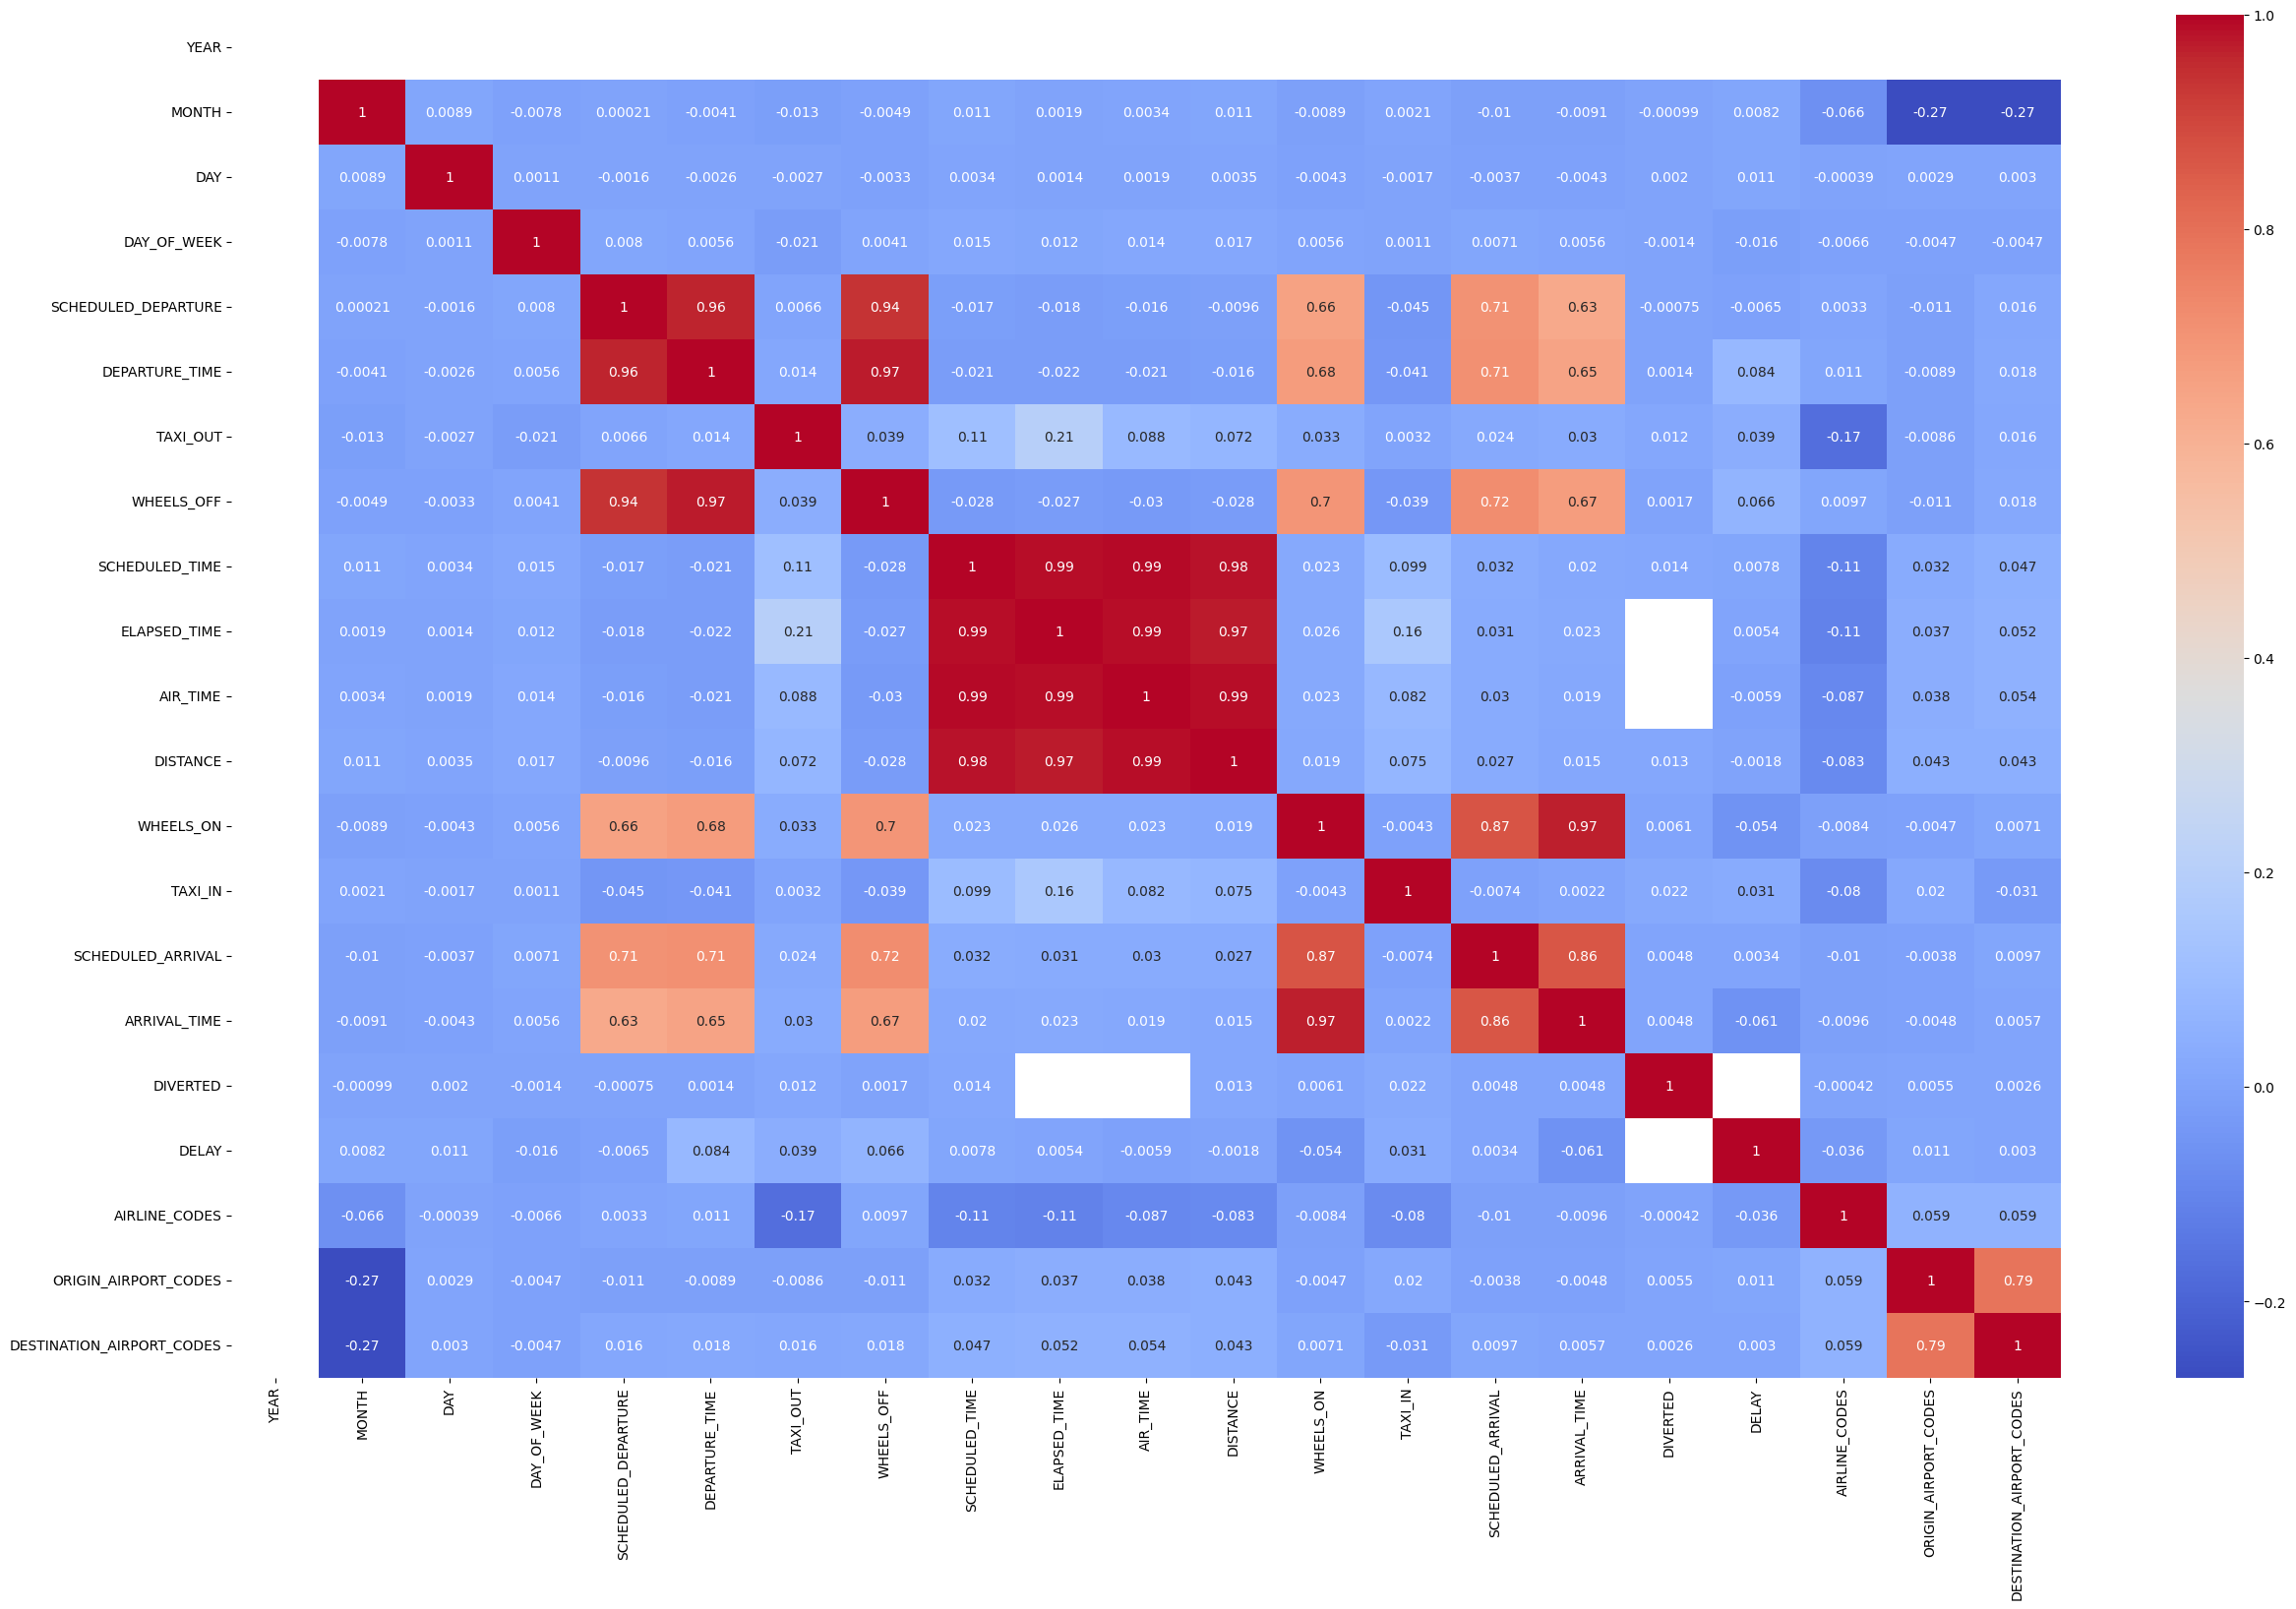

In [43]:
plt.figure(figsize=(30,18))
sns.heatmap(flight_df.corr(), annot=True, cmap='coolwarm')

In [44]:
train_df, test_df = train_test_split(flight_df, test_size=0.2, random_state=42)

x_train = train_df.drop('DELAY', axis=1)
y_train = train_df['DELAY'].fillna(0)
x_test = test_df.drop('DELAY', axis=1)
y_test = test_df['DELAY'].fillna(0)

In [45]:
xgb_model = XGBRegressor(objective='reg:squarederror',
                        n_estimators=100, 
                        learning_rate=0.1, 
                        max_depth=6, 
                        tree_method='hist',
                        device='cuda',
                        random_state=42,
                        n_jobs=-1,
                        verbose=1)
xgb_model.fit(x_train, y_train)

c:\Program Files\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
rf_model = baseline_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",   # good starting heuristic for RF
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rf_model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 4 of 100
building tree 3 of 100
building tree 5 of 100
building tree 15 of 100
building tree 12 of 100
building tree 8 of 100
building tree 7 of 100
building tree 11 of 100
building tree 10 of 100
building tree 14 of 100
building tree 13 of 100
building tree 9 of 100
building tree 16 of 100
building tree 2 of 100
building tree 6 of 100
